<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/GRU_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import functional as F

In [ ]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [ ]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/data_10.json"

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

Data succesfully loaded!


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

tensor_X_train = torch.Tensor(X_train)
tensor_X_val = torch.Tensor(X_val)
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)

train_dataset = TensorDataset(tensor_X_train,tensor_y_train)
val_dataset = TensorDataset(tensor_X_val,tensor_y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [ ]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [ ]:
class GRUModel(nn.Module):
    """GRUModel class extends nn.Module class and works as a constructor for GRUs.

       GRUModel class initiates a GRU module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           gru (nn.GRU): The GRU model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of GRUs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a GRU instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.to(device))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()

In [ ]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [ ]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

In [ ]:
input_dim = 13    
hidden_dim = 256
layer_dim = 2
output_dim = 10
seq_dim = 130
dropout_prob = 0.2

train_acc = []
val_acc = []

lr = 0.001
n_epochs = 200
iterations_per_epoch = len(train_dataloader)
best_acc = 0
patience, trials = 50, 0

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):

    
    tcorrect, ttotal = 0, 0
    for (x_batch, y_batch) in train_dataloader:
        model.train()
        x_batch, y_batch = [t.cuda() for t in (x_batch, y_batch)]
        y_batch = y_batch.to(torch.int64)
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

        _,pred = torch.max(out, dim=1)
        ttotal += y_batch.size(0)
        tcorrect += torch.sum(pred==y_batch).item()

    train_acc.append(100 * tcorrect / ttotal)
    
    model.eval()
    vcorrect, vtotal = 0, 0
    for x_val, y_val in val_dataloader:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        vtotal += y_val.size(0)
        vcorrect += (preds == y_val).sum().item()
    
    vacc = vcorrect / vtotal
    val_acc.append(vacc*100)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Val Acc.: {vacc:2.2%}')

    if vacc > best_acc:
        trials = 0
        best_acc = vacc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with val accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1 best model saved with val accuracy: 60.89%
Epoch 3 best model saved with val accuracy: 72.12%
Epoch:   5. Loss: 0.3318. Val Acc.: 75.76%
Epoch 5 best model saved with val accuracy: 75.76%
Epoch 7 best model saved with val accuracy: 79.83%
Epoch:  10. Loss: 0.1403. Val Acc.: 66.62%
Epoch 11 best model saved with val accuracy: 84.49%
Epoch:  15. Loss: 0.1845. Val Acc.: 85.06%
Epoch 15 best model saved with val accuracy: 85.06%
Epoch 16 best model saved with val accuracy: 87.40%
Epoch:  20. Loss: 0.0102. Val Acc.: 88.96%
Epoch 20 best model saved with val accuracy: 88.96%
Epoch:  25. Loss: 0.0512. Val Acc.: 87.36%
Epoch:  30. Loss: 0.0159. Val Acc.: 88.40%
Epoch 32 best model saved with val accuracy: 89.16%
Epoch:  35. Loss: 0.0183. Val Acc.: 88.96%
Epoch:  40. Loss: 0.0063. Val Acc.: 89.16%
Epoch 44 best model saved with val accuracy: 89.66%
Epoch:  45. Loss: 0.0104. Val Acc.: 89.03%
Epoch:  50. Loss: 0.0050. Val Acc.: 88.90%
Epoch:  55. Loss: 0.0105. Val Acc.: 87.96%
Epoch:  60.

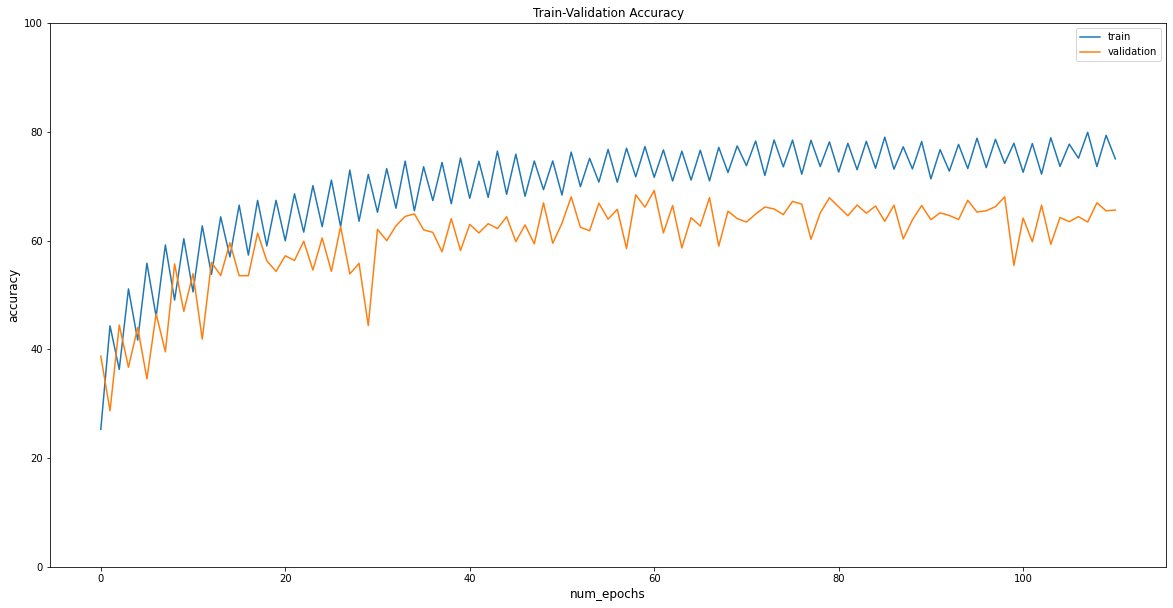

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(val_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.ylim((0,100))
#plt.xlim((0,n_epochs))

plt.legend(loc='best')

Stuff that needs tweaking

In [ ]:
import sklearn

def get_confusion_matrix(model, test_data):
    # First we make sure we disable Gradient Computing
    torch.no_grad()
    
    # Model in Evaluation Mode
    model.eval()

    preds, actuals = [], []

    for image, label in val_dataloader:
        image, label = [t.cuda() for t in (image, label)]
        #image = image.view(-1, 28, 28)
        out = model(image)

        prediction = torch.max(out, dim=1)
        preds.append(prediction)
        actuals.append(label)
    
    return sklearn.metrics.confusion_matrix(preds, actuals)

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 5))
sns.heatmap(get_confusion_matrix(model, val_dataloader), cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: LSTM', fontsize=15);



In [ ]:
model.load_state_dict(torch.load('best.pth'))

model.eval()

In [ ]:
###Needs adapting to my system

test_acc = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

